In [1]:
%matplotlib inline
import yaml
from swmm_objects_3 import *
from swmm_read_3 import *
from swmm_run_3 import *
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
# Specify MongoDB database server to use and login with credentials:    
mongoServer = 'mongodb://localhost:27017/'  # aws-2 server for GreenPhilly
database = "fengwei"
client = MongoClient(mongoServer)
db = client[database]   # use or create the database
# db.authenticate(username, password, source=authenticationDatabase)  # pass credentials to database
# Show all collections in the database:
#collectionNames = sorted(db.collection_names())
#collectionNames

# Specify the collection to use for this analysis:
lidThisCollection = "wakefield_BR_RG"
collection = "testrun2"

# Generate cursor for recalling data from simulation runs
runs = db[collection]
cursor = runs.find()
noLidRunDict = cursor[0]
# For the year chosen for analysis, specify the starting and ending times
startDateTimeAnalysisYear = datetime(2012,7,1,0,0)
endDateTimeAnalysisYear = datetime(2013,6,30,23,45)
# For the simulation recorded in the collection, specify the starting and ending times
startDateTimeSimulation = datetime(2012,8,29,0,0)
endDateTimeSimulation = datetime(2012,9,5,23,30)
# Generate the datetimeIndex for the entire simulation period
datetimeIndexEntireSimulation = pd.date_range(startDateTimeSimulation,endDateTimeSimulation,freq='15min')
#print(datetimeIndexEntireSimulation)
# Specify important files and parameters for the location:
swmmInpFileNameStr = "wingohocking_PWD_2012-13.inp"  # initial SWMM .inp file
treatmentRatio = 0.088   # cfs/imperv_acre calibrated for Wingohocking T-14 outfall 7/1/12 - 6/30/13
thresholdOutflowCFS = get_cso_threshold(swmmInpFileNameStr,treatmentRatio)
print("CSO Threshold flow rate (CFS) at outfall = {:8.2f} CFS".format(thresholdOutflowCFS))
# Generate threshold time series for plots below:
thresholdTimeSeriesCFS = pd.Series(thresholdOutflowCFS,datetimeIndexEntireSimulation)
#thresholdTimeSeriesCFS.plot()

CSO Threshold flow rate (CFS) at outfall =   274.76 CFS


# Verify that Database contains useful information by returning information from the Zero LID case cursor[0]

In [2]:
outflowCFS = noLidRunDict["outflow_seriesCFS"]
print("Outflow time series in CFS:")
print(outflowCFS)

Outflow time series in CFS:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

# Generate precipitation time series for the entire precipitation record

In [3]:
# create Pandas data frame from the weather data text file:
rain_data_file = pd.read_csv("Cohens_rain_data_philly_correct.dat", skiprows=2,header=None,delim_whitespace=True,
                              names=['city','year','month','day','hour','precip_inches'])
# Now generate a Pandas time series from the data frame created above 
# covering the entire period of the rain data file
rain_data = pd.Series()
for index, row in rain_data_file.iterrows():
    timestamp = pd.Timestamp(datetime(row['year'],row['month'],row['day'],row['hour']))
    rain_data[timestamp] = row['precip_inches']
#print(rain_data)

# Generate 15-min hyetograph for ANALYSIS YEAR

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 
.resample() is now a deferred operation
You called resample(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  # Remove the CWD from sys.path while we load stuff.


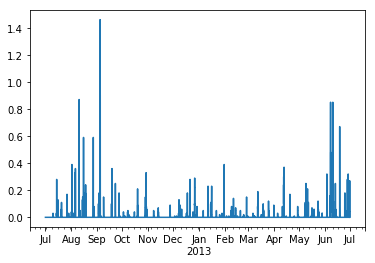

In [4]:
# reduce precipitation time series to include only the simulation period:
rain_data_simulation_period = rain_data[startDateTimeAnalysisYear:endDateTimeAnalysisYear]
# first upsample to create hourly data, repalcing NaNs with zeros

#rainDataSimulationPeriodHourly = rain_data_simulation_period.resample('H').ffill().fillna(0)
rainDataSimulationPeriodHourly = rain_data_simulation_period.resample('H')


# now create a 15 minute hyetograph series
hyetographTimeSeriesEntireSimulation = rainDataSimulationPeriodHourly.resample('15min').ffill().fillna(0)
hyetographTimeSeriesEntireSimulation.plot()


# NO LID RUN: Generate sewer outflow time series for the entire simulation period

767


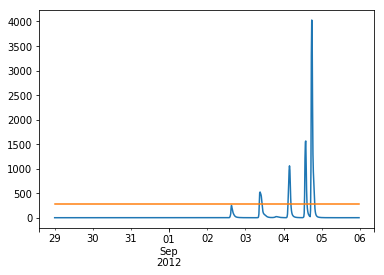

In [5]:
# Specify which run to examine graphically
noLidRunDict = cursor[0]
outflowCFS = noLidRunDict["outflow_seriesCFS"]
print(len(outflowCFS))
#datetimeLen = len(datetimeIndex)
#outflowLen = len(outflowCFS)
# Generate Pandas time series for entire simulation period
outflowTimeSeriesEntireSimulation = pd.Series(outflowCFS, index=datetimeIndexEntireSimulation)
outflowTimeSeriesEntireSimulation.plot()
thresholdTimeSeriesCFS.plot()

# Generate CSO Time series for the entire simulation period

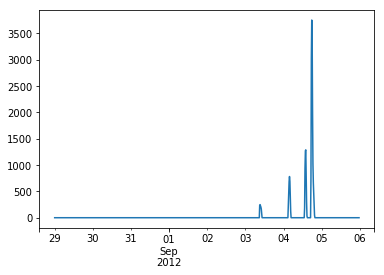

In [6]:
CSOTimeSeriesEntireSimulation = pd.Series()
for index,value in outflowTimeSeriesEntireSimulation.iteritems():
    if value > thresholdOutflowCFS:
        CSOTimeSeriesEntireSimulation[index] = value - thresholdOutflowCFS
    else:
        CSOTimeSeriesEntireSimulation[index] = 0.0
CSOTimeSeriesEntireSimulation.plot()

# Generate plots for a portion of the simulation period

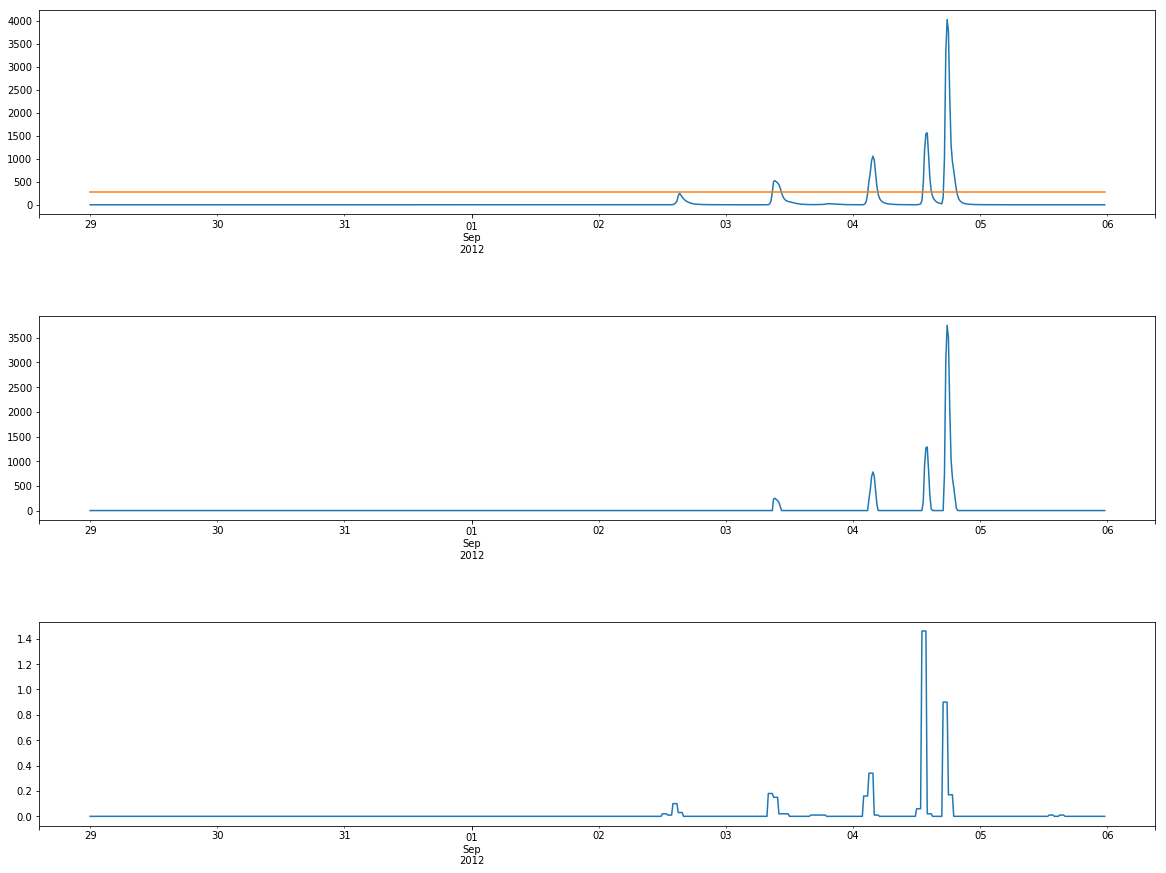

In [7]:
#startDateTimeForPlot = datetime(2012,8,29,0,15)
#endDateTimeForPlot = datetime(2012,9,5,23,45)
startDateTimeForPlot = startDateTimeSimulation
endDateTimeForPlot = endDateTimeSimulation

outflowPlot = outflowTimeSeriesEntireSimulation[startDateTimeForPlot:endDateTimeForPlot]
thresholdPlot = thresholdTimeSeriesCFS[startDateTimeForPlot:endDateTimeForPlot]
CSOPlot = CSOTimeSeriesEntireSimulation[startDateTimeForPlot:endDateTimeForPlot]
hyetographPlot = hyetographTimeSeriesEntireSimulation[startDateTimeForPlot:endDateTimeForPlot]

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(3,1,1)
outflowPlot.plot()
thresholdPlot.plot()
ax2 = fig.add_subplot(3,1,2)
CSOPlot.plot()
ax3 = fig.add_subplot(3,1,3)
hyetographPlot.plot()

#fig.align_labels(axs=None)

# Calculate Runoff and CSO Volumes for the Event Period

In [8]:
zeroLIDOutflowListCFS = outflowPlot.tolist()
# Use calculate_cso() with zero threshold to accumulate outflow rates into total outflow volume in MGal
zeroLIDOutflowVolumeForEventMGal = calculate_cso(zeroLIDOutflowListCFS,0.0)
print("Zero LID Event Runoff Flow Volume = {:8.2f} MGal".format(zeroLIDOutflowVolumeForEventMGal))
# Now use calculate_cso() with actual threshold to accumulate cso rates into total CSO volume in MGal
zeroLIDCSOVolumeForEventMGal = calculate_cso(zeroLIDOutflowListCFS,thresholdOutflowCFS)
print("Zero LID Event CSO Flow Volume = {:8.2f} MGal".format(zeroLIDCSOVolumeForEventMGal))

Zero LID Event Runoff Flow Volume =   264.66 MGal
Zero LID Event CSO Flow Volume =   167.58 MGal


# Generate Plot of CSO Reduction vs Green Acres for the Event

In [18]:
lidDictFileNameStr = "LID_Dict.yaml"
f = open(lidDictFileNameStr,'r')   
lidDict = yaml.load(f)           # Read the LID ContribImpervArea and GreenedAcres
f.close()
#print(lidDict)

plotXList = []
plotYList = []
#greenedAcresByLID_ListForAllRuns = {}
#for lid in lidDict:
#    greenedAcresByLID_ListForAllRuns[lid] = []  #initialize the list for each LID
print("Processing Data, Please Wait")
runCount = 0
cursor = runs.find()
for swmmRptDict in cursor:
    runCount += 1
    #print(runCount)
    if runCount > 1e6:
        break
    swmmInputFileStr = swmmRptDict["swmmInpFileStr"]   # retrieve the SWMM inp file used for this run as string
    #print(swmmInputFileStr)
    # for THIS run, extract total greened acres for each LID, summing over all subcatchments :
    totalGreenedAcreByLidDict = greened_acres_deployed(swmmInputFileStr,lidDict) 
    #print("totalGreenedAcreByLidDict = ",totalGreenedAcreByLidDict)
    totalGreenedAcres = 0.0
    for lid in totalGreenedAcreByLidDict:
#        greenedAcresByLID_ListForAllRuns[lid].append(totalGreenedAcreByLidDict[lid])
        totalGreenedAcres += totalGreenedAcreByLidDict[lid]  # for THIS run, accumulate total greened acres over ALL LID
    # extract a list containing outflow CFS at the outfall for this run's combination of GI placements:
    runOutflowCFS = swmmRptDict["outflow_seriesCFS"]
    # generate a Pandas time series that associates a datetime stamp with each 15 minute flow value:
    try:
        runOutflowTimeSeriesEntireSimulation = pd.Series(runOutflowCFS, index=datetimeIndexEntireSimulation)
    except:
        print("time series mismatch run number {:d}".format(runCount))
        continue
    # Slice the event data from the entire simulation:
    runOutflowForEvent = runOutflowTimeSeriesEntireSimulation[startDateTimeForPlot:endDateTimeForPlot]  

    # Generate a CSO time series for the event:
    CSOTimeSeriesEvent = pd.Series()
    for index,value in runOutflowForEvent.iteritems():
        if value > thresholdOutflowCFS:
            CSOTimeSeriesEvent[index] = value - thresholdOutflowCFS
        else:
            CSOTimeSeriesEvent[index] = 0.0        

    runOutflowForEventList = runOutflowForEvent.tolist()
    runOutflowVolumeForEventMGal = calculate_cso(runOutflowForEventList,0.0)
    #print("This Run Event Runoff Flow Volume = {:8.2f} MGal".format(runOutflowVolumeForEventMGal))
    
    runOutflowVolumeReductionForEventMGal = zeroLIDOutflowVolumeForEventMGal - runOutflowVolumeForEventMGal
    #print("This Run Event Runoff Flow Volume REDUCTION = {:8.2f} MGal".format(runOutflowVolumeReductionForEventMGal))
    
    runCSOFlowListForEventCFS = CSOTimeSeriesEvent.tolist()
    runCSOVolumeForEventMGal = calculate_cso(runCSOFlowListForEventCFS,thresholdOutflowCFS)
    #print("This Run Event CSO Flow Volume = {:8.2f} MGal".format(runCSOVolumeForEventMGal))

    runCSOReductionForEventMGal = zeroLIDCSOVolumeForEventMGal - runCSOVolumeForEventMGal
    print("This Run Event CSO Flow Volume REDUCTION = {:8.2f} MGal".format(runCSOReductionForEventMGal))
    
    plotXList.append(totalGreenedAcres)
    plotYList.append(runCSOReductionForEventMGal)
    break

testedScenarios = runCount
print(plotXList)
print(plotYList)
print("Total LID Scenarios tested = {:d}".format(testedScenarios))
print("Finished waiting")


Processing Data, Please Wait
This Run Event CSO Flow Volume REDUCTION =    47.00 MGal
[0.0]
[47.00244567153064]
Total LID Scenarios tested = 1
Finished waiting


# Generate the Plot

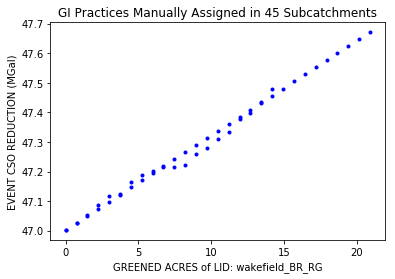

In [15]:
plt.title("GI Practices Manually Assigned in 45 Subcatchments")
plt.plot(plotXList, plotYList, '.b')
#plt.legend(loc='best')
xLabelStr = "GREENED ACRES of LID: {:s}".format(lidThisCollection)
plt.xlabel(xLabelStr)
plt.ylabel('EVENT CSO REDUCTION (MGal)')
#plt.xlim( [3000,3300])
#plt.ylim( [1100,1190] )
plt.show()